In [2]:
import math
import random
import pickle
import itertools

import numpy as np 
import pandas as pd

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, label_ranking_average_precision_score, label_ranking_loss, coverage_error 

from sklearn.utils import shuffle

from scipy.signal import resample

import matplotlib.pyplot as plt

import pickle
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Softmax, Add, Flatten, Activation# , Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint

import os
print(os.listdir("data"))

['mitbih_test.csv.zip', 'mitbih_train.csv.zip', 'ptbdb_abnormal.csv.zip', 'ptbdb_normal.csv.zip']


In [4]:
df = pd.read_csv("data/mitbih_train.csv", header=None)
df2 = pd.read_csv("data/mitbih_test.csv", header=None)
df = pd.concat([df, df2], axis=0)

In [5]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109446 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 157.8 MB


In [7]:
df[187].value_counts()

0.0    90589
4.0     8039
2.0     7236
1.0     2779
3.0      803
Name: 187, dtype: int64

In [8]:
M = df.values
X = M[:, :-1]
y = M[:, -1].astype(int)

In [9]:
del df
del df2
del M

In [10]:
C0 = np.argwhere(y == 0).flatten()
C1 = np.argwhere(y == 1).flatten()
C2 = np.argwhere(y == 2).flatten()
C3 = np.argwhere(y == 3).flatten()
C4 = np.argwhere(y == 4).flatten()

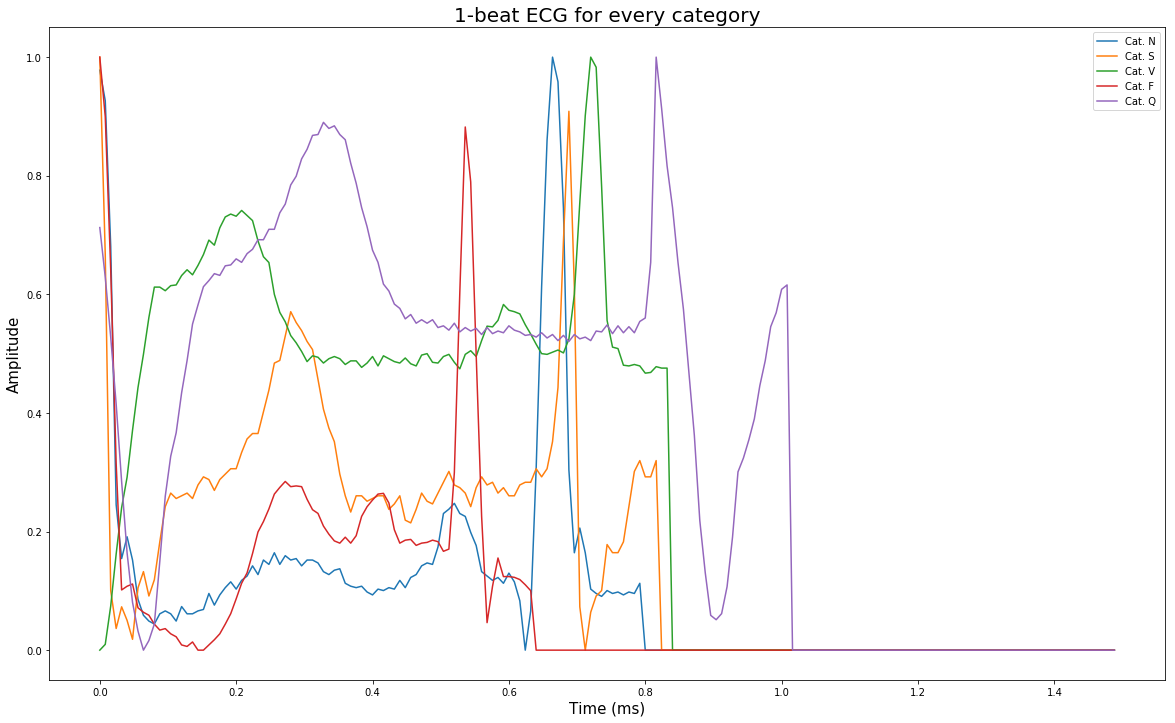

In [11]:
x = np.arange(0, 187)*8/1000

plt.figure(figsize=(20,12))
plt.plot(x, X[C0, :][0], label="Cat. N")
plt.plot(x, X[C1, :][0], label="Cat. S")
plt.plot(x, X[C2, :][0], label="Cat. V")
plt.plot(x, X[C3, :][0], label="Cat. F")
plt.plot(x, X[C4, :][0], label="Cat. Q")
plt.legend()
plt.title("1-beat ECG for every category", fontsize=20)
plt.ylabel("Amplitude", fontsize=15)
plt.xlabel("Time (ms)", fontsize=15)
plt.show()

In [12]:
def stretch(x):
    l = int(187 * (1 + (random.random()-0.5)/3))
    y = resample(x, l)
    if l < 187:
        y_ = np.zeros(shape=(187, ))
        y_[:l] = y
    else:
        y_ = y[:187]
    return y_

def amplify(x):
    alpha = (random.random()-0.5)
    factor = -alpha*x + (1+alpha)
    return x*factor

def augment(x):
    result = np.zeros(shape= (4, 187))
    for i in range(3):
        if random.random() < 0.33:
            new_y = stretch(x)
        elif random.random() < 0.66:
            new_y = amplify(x)
        else:
            new_y = stretch(x)
            new_y = amplify(new_y)
        result[i, :] = new_y
    return result

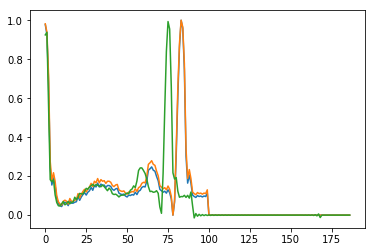

In [13]:
plt.plot(X[0, :])
plt.plot(amplify(X[0, :]))
plt.plot(stretch(X[0, :]))
plt.show()

In [14]:
result = np.apply_along_axis(augment, axis=1, arr=X[C3]).reshape(-1, 187)
classe = np.ones(shape=(result.shape[0],), dtype=int)*3
X = np.vstack([X, result])
y = np.hstack([y, classe])

In [15]:
subC0 = np.random.choice(C0, 800)
subC1 = np.random.choice(C1, 800)
subC2 = np.random.choice(C2, 800)
subC3 = np.random.choice(C3, 800)
subC4 = np.random.choice(C4, 800)

In [16]:
X_test = np.vstack([X[subC0], X[subC1], X[subC2], X[subC3], X[subC4]])
y_test = np.hstack([y[subC0], y[subC1], y[subC2], y[subC3], y[subC4]])

X_train = np.delete(X, [subC0, subC1, subC2, subC3, subC4], axis=0)
y_train = np.delete(y, [subC0, subC1, subC2, subC3, subC4], axis=0)

X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=0)

del X
del y

In [17]:
X_train = np.expand_dims(X_train, 2)
X_test = np.expand_dims(X_test, 2)

In [18]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (109150, 187, 1)
y_train (109150,)
X_test (4000, 187, 1)
y_test (4000,)


In [19]:
ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train.reshape(-1,1))
y_test = ohe.transform(y_test.reshape(-1,1))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [20]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (109150, 187, 1)
y_train (109150, 5)
X_test (4000, 187, 1)
y_test (4000, 5)


# Model

Now let's re-create the model from the ArXiv Document

In [21]:
n_obs, feature, depth = X_train.shape
batch_size = 500

In [22]:
K.clear_session()

inp = Input(shape=(feature, depth))
C = Conv1D(filters=32, kernel_size=5, strides=1)(inp)

C11 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(C)
A11 = Activation("relu")(C11)
C12 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A11)
S11 = Add()([C12, C])
A12 = Activation("relu")(S11)
M11 = MaxPooling1D(pool_size=5, strides=2)(A12)


C21 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M11)
A21 = Activation("relu")(C21)
C22 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A21)
S21 = Add()([C22, M11])
A22 = Activation("relu")(S11)
M21 = MaxPooling1D(pool_size=5, strides=2)(A22)


C31 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M21)
A31 = Activation("relu")(C31)
C32 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A31)
S31 = Add()([C32, M21])
A32 = Activation("relu")(S31)
M31 = MaxPooling1D(pool_size=5, strides=2)(A32)


C41 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M31)
A41 = Activation("relu")(C41)
C42 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A41)
S41 = Add()([C42, M31])
A42 = Activation("relu")(S41)
M41 = MaxPooling1D(pool_size=5, strides=2)(A42)


C51 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M41)
A51 = Activation("relu")(C51)
C52 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A51)
S51 = Add()([C52, M41])
A52 = Activation("relu")(S51)
M51 = MaxPooling1D(pool_size=5, strides=2)(A52)

F1 = Flatten()(M51)

D1 = Dense(32)(F1)
A6 = Activation("relu")(D1)
D2 = Dense(32)(A6)
D3 = Dense(5)(D2)
A7 = Softmax()(D3)

model = Model(inputs=inp, outputs=A7)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 187, 1)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 183, 32)      192         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 183, 32)      5152        conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 183, 32)      0           conv1d_2[0][0]                   
__________________________________________________________________________________________________
conv1d_3 (

In [23]:
def exp_decay(epoch):
    initial_lrate = 0.001
    k = 0.75
    t = n_obs//(10000 * batch_size)  # every epoch we do n_obs/batch_size iteration
    lrate = initial_lrate * math.exp(-k*t)
    return lrate

lrate = LearningRateScheduler(exp_decay)

In [24]:
adam = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)

In [25]:
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [26]:
history = model.fit(X_train, y_train, 
                    epochs=75, 
                    batch_size=batch_size, 
                    verbose=2, 
                    validation_data=(X_test, y_test), 
                    callbacks=[lrate])

Train on 109150 samples, validate on 4000 samples
Epoch 1/75
 - 20s - loss: 0.3798 - acc: 0.8865 - val_loss: 0.8485 - val_acc: 0.7302
Epoch 2/75
 - 20s - loss: 0.1464 - acc: 0.9610 - val_loss: 0.7615 - val_acc: 0.8052
Epoch 3/75
 - 20s - loss: 0.1072 - acc: 0.9709 - val_loss: 0.5101 - val_acc: 0.8520
Epoch 4/75
 - 19s - loss: 0.0880 - acc: 0.9755 - val_loss: 0.6352 - val_acc: 0.8415
Epoch 5/75
 - 19s - loss: 0.0742 - acc: 0.9791 - val_loss: 0.3554 - val_acc: 0.8895
Epoch 6/75
 - 19s - loss: 0.0676 - acc: 0.9805 - val_loss: 0.4082 - val_acc: 0.8760
Epoch 7/75
 - 18s - loss: 0.0610 - acc: 0.9822 - val_loss: 0.3956 - val_acc: 0.8720
Epoch 8/75
 - 18s - loss: 0.0567 - acc: 0.9831 - val_loss: 0.3110 - val_acc: 0.9070
Epoch 9/75
 - 18s - loss: 0.0524 - acc: 0.9845 - val_loss: 0.3782 - val_acc: 0.8858
Epoch 10/75
 - 18s - loss: 0.0477 - acc: 0.9853 - val_loss: 0.2857 - val_acc: 0.9105
Epoch 11/75
 - 18s - loss: 0.0445 - acc: 0.9863 - val_loss: 0.2361 - val_acc: 0.9228
Epoch 12/75
 - 18s - los

In [27]:
y_pred = model.predict(X_test, batch_size=1000)

In [28]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.85      0.99      0.92       800
           1       0.99      0.86      0.92       800
           2       0.90      0.96      0.93       800
           3       0.99      0.88      0.93       800
           4       0.99      0.99      0.99       800

   micro avg       0.94      0.94      0.94      4000
   macro avg       0.94      0.94      0.94      4000
weighted avg       0.94      0.94      0.94      4000



In [29]:
print("ranking-based average precision : {:.3f}".format(label_ranking_average_precision_score(y_test.todense(), y_pred)))
print("Ranking loss : {:.3f}".format(label_ranking_loss(y_test.todense(), y_pred)))
print("Coverage_error : {:.3f}".format(coverage_error(y_test.todense(), y_pred)))

ranking-based average precision : 0.967
Ranking loss : 0.019
Coverage_error : 1.074


Confusion matrix, without normalization


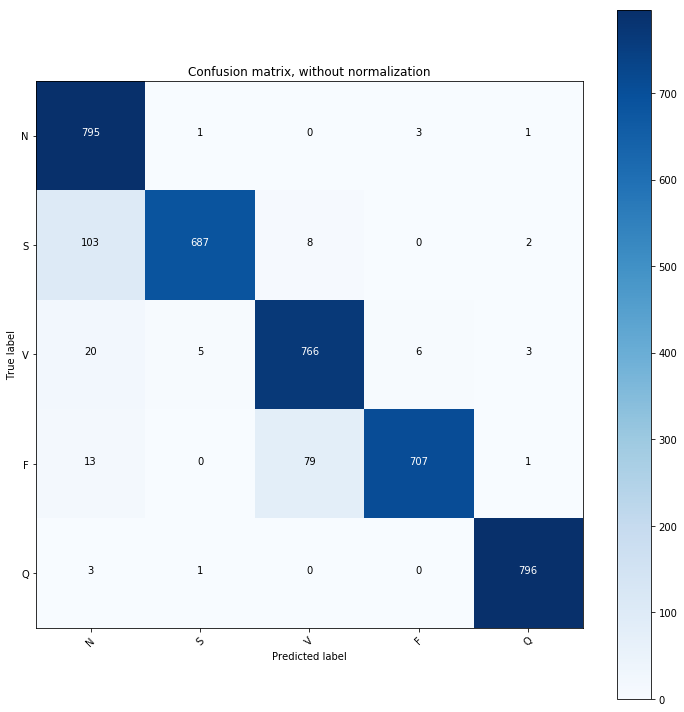

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],
                      title='Confusion matrix, without normalization')
plt.show()

In [31]:
from tensorflow.keras.models import load_model

model.save('wave2disease.h5')